# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

#### Run this cell to load the data:

In [2]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Merge train and test set

In [3]:
df = pd.concat([train,test])

In [4]:
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


## Feature Engineering

In [5]:
df = df.drop(columns=['Inspection ID', 'License #', 'Latitude', 'Longitude', 'Location'])

In [6]:
df['no_violation'] = df['Violations'].isna()

In [7]:
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'], infer_datetime_format=True)
df['Inspection Date'] = pd.Timestamp.today() - df['Inspection Date']
df['Inspection Date'] = df['Inspection Date'].dt.days

### Define X and y

In [8]:
y = df['Fail']

In [9]:
X = df.drop(columns=['Fail'])

### Encode Train and Test together to ensure feature consistency. 

In [10]:
import category_encoders as ce

In [11]:
encoder = ce.BinaryEncoder(handle_unknown='ignore')

In [12]:
X = encoder.fit_transform(X)

### Train Test Split - I chose this format because native XGBoost is easier to work with if a proper train/test split is done

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### I prefer using XGB standard API rather than it's sklearn wrapper - turn test/train sets into DMatrices

In [15]:
import xgboost as xgb

In [16]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [17]:
dtest = xgb.DMatrix(X_test, label=y_test)

## Note: Parameters are chosen to be fast - I would have been able to optimize for ROC_AUC better with these if I wasn't worried about compute time
___

In [18]:
params = {
        
        'monotone_constraints': '(0)', # no constraint
        'eta' : 0.3 ,
        'min_child_weight': 7,
        'max_depth' : 9,
        #'gamma' : 0.2,
        'max_delta_step' : 0,
        'subsample' : 1,
        'colsample_bytree' : 0.9,
        # 'colsample_bylevel' : 1,
        'alpha' : 0,
        'scale_pos_weight' : 1,
        'eval_metric' : "auc",
        'silent' : 1,
        'n_jobs' : -1,
          
         }

## First Crossval

In [19]:
bst_cv = xgb.cv(params, dtrain, num_boost_round=1000, nfold=5, early_stopping_rounds=10, as_pandas=True)

In [20]:
bst_cv.describe()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
count,9.000000,9.000000,9.000000,9.000000
mean,0.807696,0.002650,0.730892,0.004470
std,0.039724,0.000881,0.019342,0.001105
min,0.721342,0.002024,0.681242,0.003119
25%,0.794770,0.002094,0.733803,0.003750
50%,0.813554,0.002258,0.739375,0.004371
75%,0.833653,0.002880,0.740299,0.004677
max,0.851884,0.004740,0.740411,0.006748


# Chris-search CV
____

## 1. Max Depth and Min Child Weight

In [21]:
#Define our parameters to search
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]


In [22]:
# Define initial best params and AUC
max_auc = float(0)
best_params = []
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params, dtrain, num_boost_round=1000, nfold=5, early_stopping_rounds=10, seed = 42,
    )

    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print("  AUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = [max_depth,min_child_weight]

print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))


CV with max_depth=9, min_child_weight=5
  AUC 0.7398464 for 7 rounds
CV with max_depth=9, min_child_weight=6
  AUC 0.7415548 for 9 rounds
CV with max_depth=9, min_child_weight=7
  AUC 0.7401440000000001 for 5 rounds
CV with max_depth=10, min_child_weight=5
  AUC 0.7364687999999999 for 5 rounds
CV with max_depth=10, min_child_weight=6
  AUC 0.7371551999999999 for 5 rounds
CV with max_depth=10, min_child_weight=7
  AUC 0.7374272000000001 for 6 rounds
CV with max_depth=11, min_child_weight=5
  AUC 0.7285554 for 6 rounds
CV with max_depth=11, min_child_weight=6
  AUC 0.7299854 for 5 rounds
CV with max_depth=11, min_child_weight=7
  AUC 0.7313436 for 4 rounds
Best params: 9, 6, AUC: 0.7415548


In [23]:
params['max_depth'] = 9
params['min_child_weight'] = 6

## 2. Subsample and Colsample_by_tree

In [24]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [25]:
# Define initial best params and AUC
max_auc = float(0)
best_params = []

for subsample, colsample in reversed (gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params, dtrain, num_boost_round=2000, nfold=5, early_stopping_rounds=60, seed = 42,
    )

    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print("   AUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = [subsample,colsample]

print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with subsample=1.0, colsample=1.0
   AUC 0.7409817999999999 for 5 rounds
CV with subsample=1.0, colsample=0.9
   AUC 0.7415548 for 9 rounds
CV with subsample=1.0, colsample=0.8
   AUC 0.7391702 for 11 rounds
CV with subsample=1.0, colsample=0.7
   AUC 0.7346386 for 11 rounds
CV with subsample=0.9, colsample=1.0
   AUC 0.7399652 for 8 rounds
CV with subsample=0.9, colsample=0.9
   AUC 0.7382025999999999 for 5 rounds
CV with subsample=0.9, colsample=0.8
   AUC 0.7372852 for 8 rounds
CV with subsample=0.9, colsample=0.7
   AUC 0.730727 for 10 rounds
CV with subsample=0.8, colsample=1.0
   AUC 0.7386272 for 4 rounds
CV with subsample=0.8, colsample=0.9
   AUC 0.7339619999999999 for 5 rounds
CV with subsample=0.8, colsample=0.8
   AUC 0.7347430000000001 for 5 rounds
CV with subsample=0.8, colsample=0.7
   AUC 0.7313097999999999 for 10 rounds
CV with subsample=0.7, colsample=1.0
   AUC 0.7343713999999999 for 5 rounds
CV with subsample=0.7, colsample=0.9
   AUC 0.7343204 for 4 rounds
CV wi

In [26]:
params['subsample'] = 1
params['colsample_bytree'] = 0.9

## 3. Learning rate / ETA

In [27]:
# Define initial best params and AUC
max_auc = float(0)
best_params = []

for eta in [.3, .2, .1, .05,]:
    print("CV with eta={}".format(eta))

   
    # We update our parameters
    params['eta'] = eta

    # Run CV
    cv_results = xgb.cv(
        params, dtrain, num_boost_round=2000, nfold=5, early_stopping_rounds=60, seed = 42,
    )

    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print("  AUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = eta

print("Best params: {},  AUC: {}".format(best_params, max_auc))


CV with eta=0.3
  AUC 0.7415548 for 9 rounds
CV with eta=0.2
  AUC 0.7468011999999999 for 17 rounds
CV with eta=0.1
  AUC 0.7556177999999999 for 109 rounds
CV with eta=0.05
  AUC 0.7590425999999999 for 173 rounds
Best params: 0.05,  AUC: 0.7590425999999999


In [28]:
params['eta'] = 0.05

# Evaluating on the test set
____

In [29]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-auc:0.67861
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.724318
[2]	Test-auc:0.729185
[3]	Test-auc:0.731296
[4]	Test-auc:0.732827
[5]	Test-auc:0.732359
[6]	Test-auc:0.732833
[7]	Test-auc:0.734447
[8]	Test-auc:0.735029
[9]	Test-auc:0.735267
[10]	Test-auc:0.736005
[11]	Test-auc:0.736207
[12]	Test-auc:0.736915
[13]	Test-auc:0.737678
[14]	Test-auc:0.737783
[15]	Test-auc:0.737772
[16]	Test-auc:0.738213
[17]	Test-auc:0.738455
[18]	Test-auc:0.739282
[19]	Test-auc:0.739521
[20]	Test-auc:0.739777
[21]	Test-auc:0.740348
[22]	Test-auc:0.74055
[23]	Test-auc:0.740773
[24]	Test-auc:0.741044
[25]	Test-auc:0.741769
[26]	Test-auc:0.742116
[27]	Test-auc:0.742612
[28]	Test-auc:0.742399
[29]	Test-auc:0.74286
[30]	Test-auc:0.742916
[31]	Test-auc:0.743165
[32]	Test-auc:0.743102
[33]	Test-auc:0.743267
[34]	Test-auc:0.743435
[35]	Test-auc:0.743482
[36]	Test-auc:0.743691
[37]	Test-auc:0.743626
[38]	Test-auc:0.743576
[39]	Test-auc:0.743526
[40]	Test-auc:0.743716
[41]	Test-auc:

In [30]:
print("Best AUC: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best AUC: 0.75 in 140 rounds


## Saving Best Model

In [49]:
model.save_model("my_model3.model")

## Load Best Model into sklearn

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score


from xgboost.sklearn import XGBClassifier

In [68]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [71]:
clf = XGBClassifier()
booster = xgb.Booster()
booster.load_model('my_model3.model')
clf._Booster = booster
clf._le = le.fit(y_test)

In [74]:
clf.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0])

## Use SkLearn API because it has better support for visualizations

In [72]:
import matplotlib.pyplot as plt

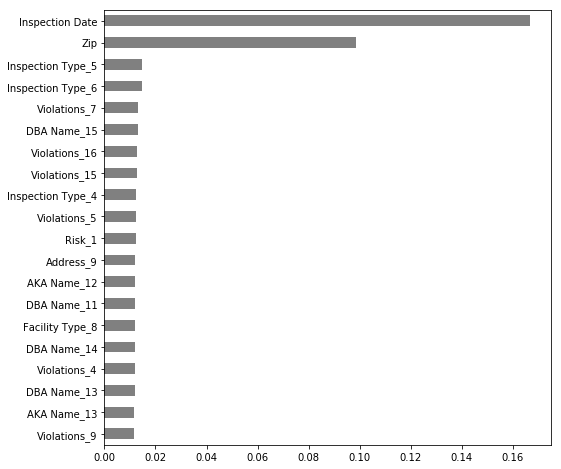

In [75]:
def show_feature_importances(gclassifier, X, n=20, figsize=(8, 8)):
    
    # pipe must not change dimensions of X dataframe
    
    importances = pd.Series(
        gclassifier.feature_importances_, 
        X.columns)

    top_n = importances.sort_values(ascending=False)[:n]
    
    plt.figure(figsize=figsize)
    top_n.sort_values().plot.barh(color='grey')

    
show_feature_importances(clf,X)

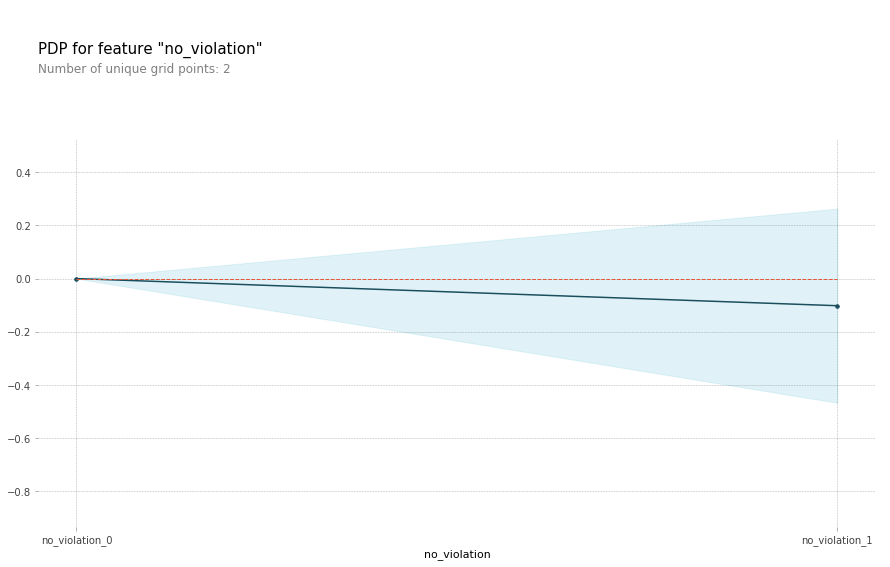

In [76]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='no_violation'
pdp_isolated = pdp_isolate(model=clf, dataset=X_train, model_features=X_train.columns, feature=feature)
pdp_plot(pdp_isolated, feature);